In [ ]:
using Pkg; Pkg.activate("C:\\Users\\KarlH\\Desktop\\ComputationalPhysicsMaster\\Code\\OrbitalNeuralMethods")
using Revise
using OrbitalNeuralMethods

In [ ]:
using PyFormattedStrings
import Plots as plt

In [ ]:
l = 10
ω = 0.25
basis = SpinBasis(HOBasis(l, ω))

n = 2
V = ShieldedCoulomb(0.25)
grid = [x for x in range(-10, stop = 10, length = 2001)]
system = System(n, basis, grid, V);

In [ ]:
hf = setup_HF(system);
compute_ground_state!(hf, max_iter = 1000, tol = 1e-10)

rhf = setup_RHF(system);
compute_ground_state!(rhf, max_iter = 1000, tol = 1e-10)

## Density Setup

In [8]:
function single_det_particle_density(system)
    (;spfs, n) = system
    
    particle_density = zero(spfs[1])
    for i in 1:n
        particle_density .+= spfs[i].^2
    end
    return particle_density
end

single_det_particle_density (generic function with 1 method)

In [9]:
function CCSD_particle_density(state)
    (;system, t1) = state
    (;spfs, l, n)  = system
    
    cc_dens = zero(spfs[1])
    for p in 1:l
        for q in 1:l
            if p == q && p <= n
                cc_dens .+= spfs[p] .* spfs[q]
            elseif q <= n && p > n
                cc_dens .+= spfs[p] .* spfs[q] .* t1[p, q]
            end
        end
    end
    return cc_dens
end

CCSD_particle_density (generic function with 1 method)

In [44]:
import FileIO
import ColorVectorSpace
function imgplot(;file, extent, imgalpha, xticks, yticks)
    img = FileIO.load(file) .- ColorVectorSpace.RGBA(0, 0, 0, 1 - imgalpha)
    
    h, w = size(img)
    x0, x1, y0, y1 = extent
    dx = x1 - x0
    x_mid = (x0 + x1) / 2
    dy = y1 - y0
    
    plt.plot(img,
             xlim = (0, w),
             ylim = (0, h),
             yticks = h .- (yticks .- y0) .* h ./ dy,
             xticks = (xticks .+ dx ./ 2) .* w ./ dx,
             grid = true, gridalpha = 0.7,
             size = (600, 400),
             xformatter = x -> round((x / w - 0.5 + x_mid/dx) * dx, digits = 1),
             yformatter = y -> round((-y / h * dy + y0 + dy), digits = 10),
             )
    return x -> (x - x_mid + dx/2) * w / dx, y -> h - (y - y0) * h / dy
end

imgplot (generic function with 1 method)

## Particle Density

In [14]:
sys_rhf = System(rhf)
rhf_density = single_det_particle_density(sys_rhf)
sys_hf = System(hf)
hf_density = single_det_particle_density(sys_hf)

ccsd_rhf = setup_CCSD(sys_rhf)
compute_ground_state!(ccsd_rhf);
ccsd_rhf_density = CCSD_particle_density(ccsd_rhf)

ccsd_hf = setup_CCSD(sys_hf)
compute_ground_state!(ccsd_hf);
ccsd_hf_density = CCSD_particle_density(ccsd_hf);

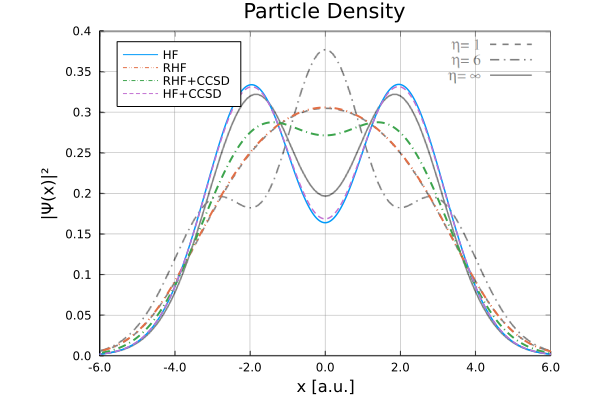

In [71]:
x_trans, y_trans = imgplot(file     = "Figures/GS.PNG",
                           extent   = [-6, 6, 0, 0.4],
                           imgalpha = 0.5,
                           yticks   = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4],
                           xticks   = [x for x in -6:2:6],
                           )

plt.plot!(legend=:topleft, title="Particle Density", xlabel="x [a.u.]", ylabel="|Ψ(x)|²")
plt.plot!(x_trans.(grid), y_trans.(hf_density), label="HF", lw=1.5, c=1)
plt.plot!(x_trans.(grid), y_trans.(rhf_density), label="RHF", ls=:dashdotdot, lw=2, c=2)
plt.plot!(x_trans.(grid), y_trans.(ccsd_rhf_density), label="RHF+CCSD", ls=:dashdot, lw=2, c=3)
plt.plot!(x_trans.(grid), y_trans.(ccsd_hf_density), label="HF+CCSD", ls=:dash, lw=1.5, c=4)
plt.savefig("Figures/particle_dens_zang.png")
plt.plot!()

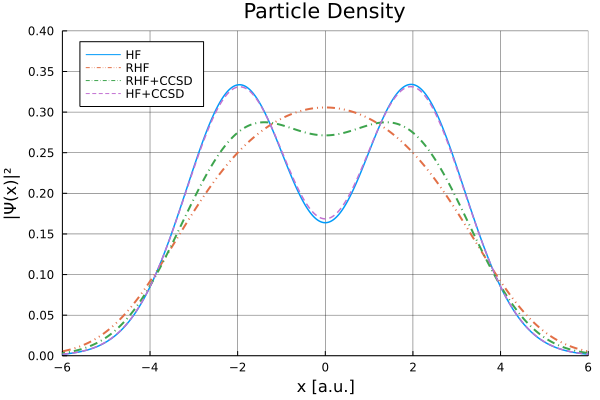

In [70]:
plt.plot(legend=:topleft, title="Particle Density", xlabel="x [a.u.]", ylabel="|Ψ(x)|²", xlim=(-6, 6), ylim=(0, 0.4), grid = true, gridalpha = 0.7,
        xticks=[x for x in -6:2:6], yticks=[y for y in 0:0.05:0.4], size = (600, 400))
plt.plot!(grid, hf_density, label="HF", lw=1.5, c=1)
plt.plot!(grid, rhf_density, label="RHF", ls=:dashdotdot, lw=2, c=2)
plt.plot!(grid, ccsd_rhf_density, label="RHF+CCSD", ls=:dashdot, lw=2, c=3)
plt.plot!(grid, ccsd_hf_density, label="HF+CCSD", ls=:dash, lw=1.5, c=4)
plt.savefig("Figures/particle_dens.png")
plt.plot!()